## PCA Task

 Perform PCA-based anomaly detection.

###  Load the data

 

In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import decomposition
from pca_helper_functions import *
from comparison_helper_functions import *
%matplotlib inline


# Load the datasets from the saved numpy arrays in the Familiarization task
X = np.load('./train_data.npy')
y = np.load('./train_labels.npy')
X_test = np.load('./test_data.npy')

train_data = pd.read_pickle('./train_data_df.pkl')

# Seperate the two training datasets
# X1, y1 = training data and labels 1 (normal behaviour)
# X2, y2 = training data and labels 2 (attacks present)
num = 8761
X1 = X[:num]
X2 = X[num:]
y1 = y[:num]
y2 = y[num:]

# Check that everything is there
print("Training dataset shape: ", X.shape)
print("Test dataset shape: ", X_test.shape)
print("Number of attacks: ", np.sum(y==1))


Training dataset shape:  (12938, 40)
Test dataset shape:  (2089, 40)
Number of attacks:  219


### Normalize the train data to have zero mean to apply pca

- Usefull visualizations: that show the number of components that capture the majority of the variance.
   

[0.19612305 0.31662018 0.43230526 0.52360839 0.58867985 0.65065948
 0.70066975 0.75053028 0.7890944  0.82060956 0.85005591 0.87476162
 0.8990998  0.92122835 0.94233345 0.96109835 0.97773725 0.98848145
 0.99497675 0.99681129 0.99778659 0.99848837 0.9990731  0.99941448
 0.9996421  0.99982645 0.99988703 0.99993342 0.99995854 0.99997081
 0.99997846 0.99998583 0.9999908  0.99999567 0.99999846 0.99999997
 1.         1.         1.         1.        ]


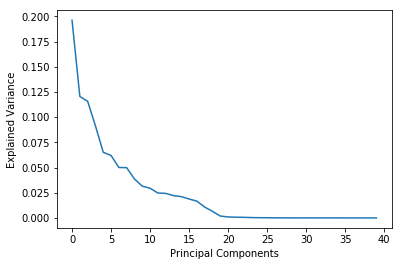

In [94]:
#Normalize - apply model 
normalize = StandardScaler()
n_data = normalize.fit_transform(X1)

model = PCA( n_components= X1.shape[1])
p_data = model.fit_transform(n_data)
r_data = model.inverse_transform(p_data)


#print cummulative variance 
cummulative_variance=model.explained_variance_ratio_.cumsum()
print(cummulative_variance)


#plot the variance ratio
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.plot(model.explained_variance_ratio_)


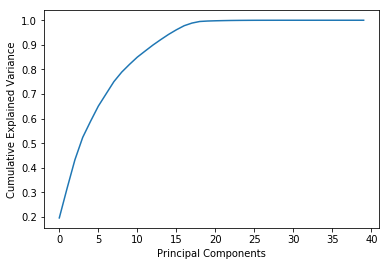

In [95]:
#plot the cumulative variance to determine the number of components 
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.plot(model.explained_variance_ratio_.cumsum())

### Find the number of principal componets  that capture the majority of the variance 
- We selected the variance = 95% captured by 16 components, because from the figures above we observed that 15 or 16 principal components captures the majority of the variance in the data.  

In [96]:
eigenvalues = model.explained_variance_

#function that determines the number of components 
num , variance = optimal_components(eigenvalues, 0.95)
print("Number of componetns:", num)

Number of componetns: 16


- Apply pca with the selected number of components to the train data and compute the residual (spe)

In [98]:
#fit and transform the new model and construct the inverse matrix.

pca = PCA(n_components= num)
np_data = pca.fit_transform(n_data)
rec_data = pca.inverse_transform(np_data)
print(np_data.shape)
print('{:0.0%} of variance is captured'.format(sum(pca.explained_variance_ratio_)))

(8761, 16)
96% of variance is captured


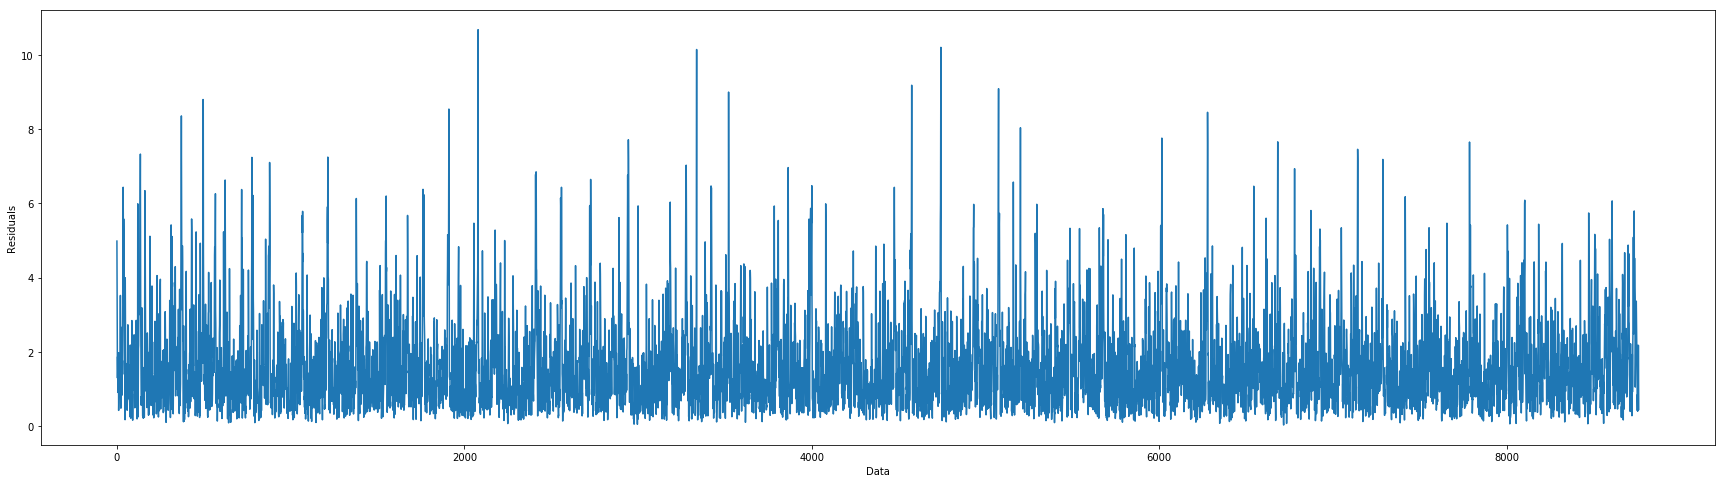

<Figure size 2160x576 with 0 Axes>

In [99]:
#function that computes the residuals 
res = compute_residuals(n_data, rec_data)


# Plot the residuals vector to check for abnormalities 
figure, ax = plt.subplots(figsize=[30,8])
plt.xlabel("Data")
plt.ylabel("Residuals")
plt.figure(figsize=[30,8])
ax.plot(res)


- The figure above shows that there are abnormalities in the train data there are some large spikes that they do not follow the distribution of the signal. We removed the outliers based on an outlier threshold.

In [136]:
# new train_data and labels 
lb= y1[res<=5] 
t_data = X1[res<= 5] 

print("Cleaned Data new shape:",t_data.shape)

Cleaned Data new shape: (8572, 40)


- Apply the same model to the new data.

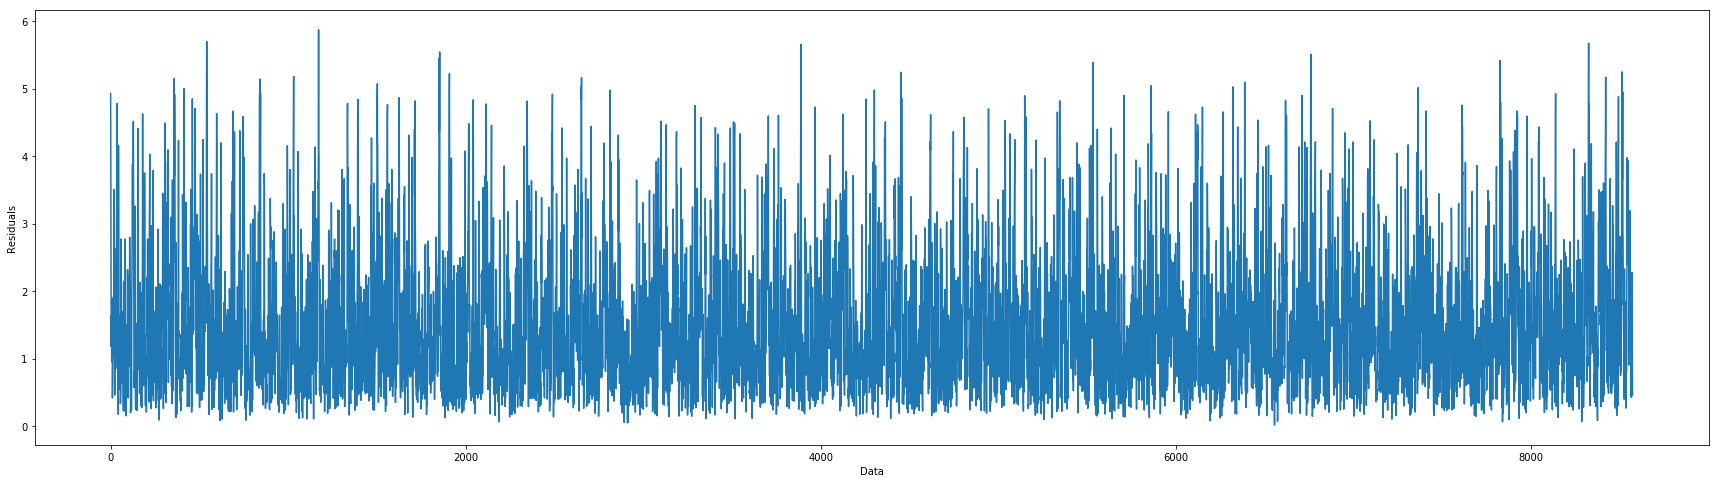

<Figure size 2160x576 with 0 Axes>

In [137]:
norm = StandardScaler()
norm_t_data = norm.fit_transform(t_data)

p_t_data = pca.fit_transform(norm_t_data)
rec_t_data = pca.inverse_transform(p_t_data)

res_t = compute_residuals(norm_t_data, rec_t_data)

# Plot the residuals vector 
figure, ax = plt.subplots(figsize=[30,8])
plt.xlabel("Data")
plt.ylabel("Residuals")
plt.figure(figsize=[30,8])
ax.plot(res_t)


### Find the optimal threshold that produces the least number of false positives
- We computed the threshold according to the paper "Diagnosing Network-Wide Traffic Anomalies" by et al Lakhina. The threshold is obtained using the Q-Statistic function.

2.5655593660525935


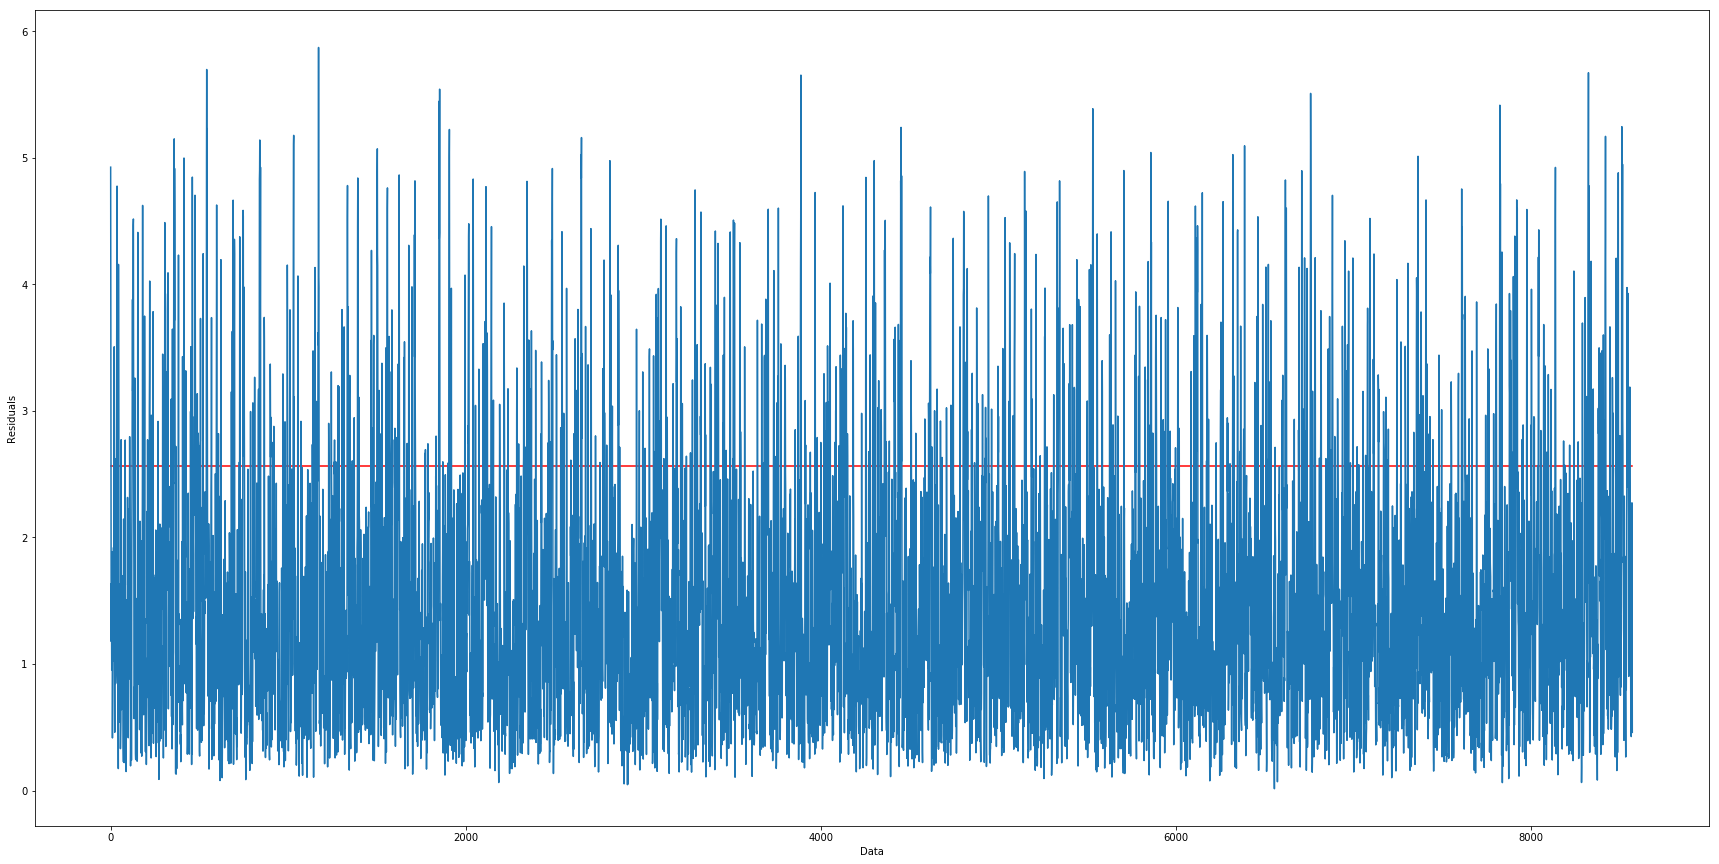

<Figure size 2160x1080 with 0 Axes>

In [138]:
# Q_stat function computes the threshold using Q_statistic function 
threshold =  Q_stat(model, num)
print(threshold)
 
#Visualizations of the obtained thresholds to the residual vector
figure, ax = plt.subplots(figsize=[30,15])
plt.xlabel("Data")
plt.ylabel("Residuals")
plt.figure(figsize=[30,15])
ax.plot([0,len(res_t)],[threshold, threshold],'r', label = 'qstat' )
ax.plot(res_t)


- As can it be seen in the figure above the threshold that was obtained from the Q_stat function is not optimal. Therefore, we decided to use our own threshold that will result to least number of false positive in the train set. 

In [140]:
#test different number of threshold, where new_threshold > threshold obtained from the q stat.
thresholds = [5.1,5.2,5.3,5.4,5.5,5.6,5.7]
for i in thresholds:
    predict =  res_t > i 
    conf = estimate_confusion_matrix(lb, predict)
    print("Threshold:", i , "results to the following confusion matrix")
    print(conf)



Threshold: 5.1 results to the following confusion matrix
[[   0   19]
 [   0 8553]]
Threshold: 5.2 results to the following confusion matrix
[[   0   13]
 [   0 8559]]
Threshold: 5.3 results to the following confusion matrix
[[   0    9]
 [   0 8563]]
Threshold: 5.4 results to the following confusion matrix
[[   0    8]
 [   0 8564]]
Threshold: 5.6 results to the following confusion matrix
[[   0    4]
 [   0 8568]]
Threshold: 5.7 results to the following confusion matrix
[[   0    1]
 [   0 8571]]


- As we can see from FP on the train data, if we set the threshold above 6.5, the fP will be 1 and then 0. We need the threshold to result to the least numbers of FP therefore we chose to use 6.4.

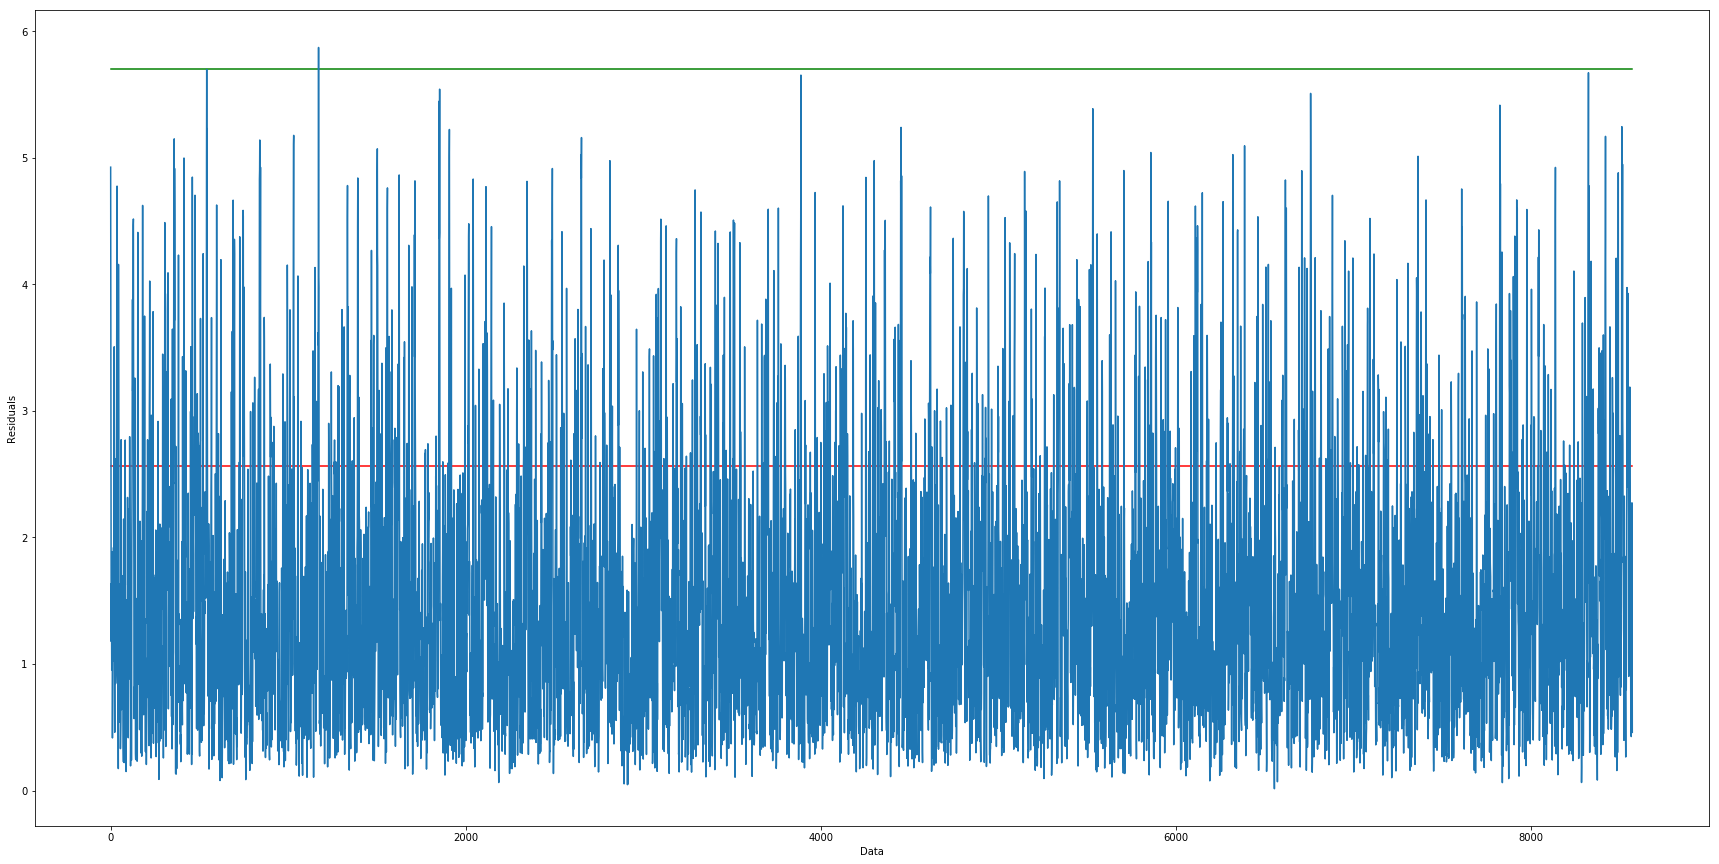

<Figure size 2160x1080 with 0 Axes>

In [141]:
#threshold that obtained the least number of false positive in the train set
new_threshold = 5.7

# visualize the new threshold and the threshold obtained from the Q_stat
figure, ax = plt.subplots(figsize=[30,15])
plt.xlabel("Data")
plt.ylabel("Residuals")
plt.figure(figsize=[30,15])
ax.plot([0,len(res_t)],[new_threshold, new_threshold],'g', label = 'new' )
ax.plot([0,len(res_t)],[threshold, threshold],'r', label = 'qstat' )
ax.plot(res_t)

### Results 
- we used the method proovided by "Diagnosing Network-Wide Traffic Anomalies" by et al Lakhina. They considered that if the Squered prediction Error is above a treshold, this is considered an anomaly. 
- We printed the results for both thresholds.

In [142]:
#detect anomalies the fuction returns the predicted labels where spe>threshold
scale= StandardScaler()
att_data = scale.fit_transform(X2)
predicted_labels = det_anomalies(norm_t_data, att_data, num, threshold)

Confusion Matrix: [[ 156  899]
 [  63 3059]]
Accuracy: 0.77
Precision: 0.15
Recall: 0.71
F_score: 0.24
Score : 0.87


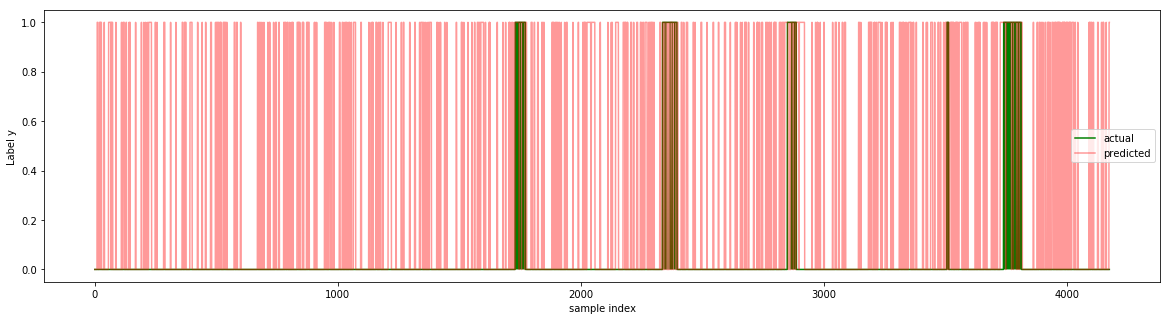

In [143]:
#print results for the first dataset
y2[y2 == -999]= 0
cm = estimate_confusion_matrix(y2, predicted_labels)
accuracy, precision, recall, F1_score = performance_metrics(cm)
c = compute_s(y2, predicted_labels, 0.5)
    
print ("Confusion Matrix:", cm)
print("Accuracy: %.2f" %accuracy)
print("Precision: %.2f" % precision)
print("Recall: %.2f" %recall)
print("F_score: %.2f" % F1_score)
print("Score : %.2f"%c)
# Visualize the predicted vs the true labels
plot(y2, predicted_labels)

Confusion Matrix: [[  45  127]
 [ 174 3831]]
Accuracy: 0.93
Precision: 0.26
Recall: 0.21
F_score: 0.23
Score : 0.71


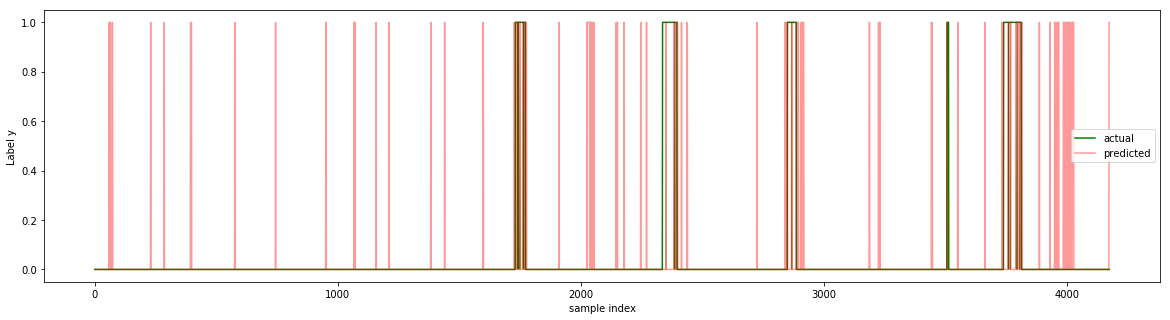

In [146]:
#detect again with the new threshold
predicted_labels2 = det_anomalies(norm_t_data,att_data, num, new_threshold)
cm1 = estimate_confusion_matrix(y2, predicted_labels2)
accuracy1, precision1, recall1, F1_score1 = performance_metrics(cm1)
c_2 = compute_s(y2, predicted_labels2, 0.5)

print ("Confusion Matrix:", cm1)
print("Accuracy: %.2f" %accuracy1)
print("Precision: %.2f" % precision1)
print("Recall: %.2f" %recall1)
print("F_score: %.2f" % F1_score1)
print("Score : %.2f"%c_2)

# Visualize the predicted vs the true labels
plot(y2, predicted_labels2)

### Results without deleting the outliers.

Confusion Matrix: [[ 160  893]
 [  59 3065]]
Accuracy: 0.77
Precision: 0.15
Recall: 0.73
F_score: 0.25
Score : 0.87


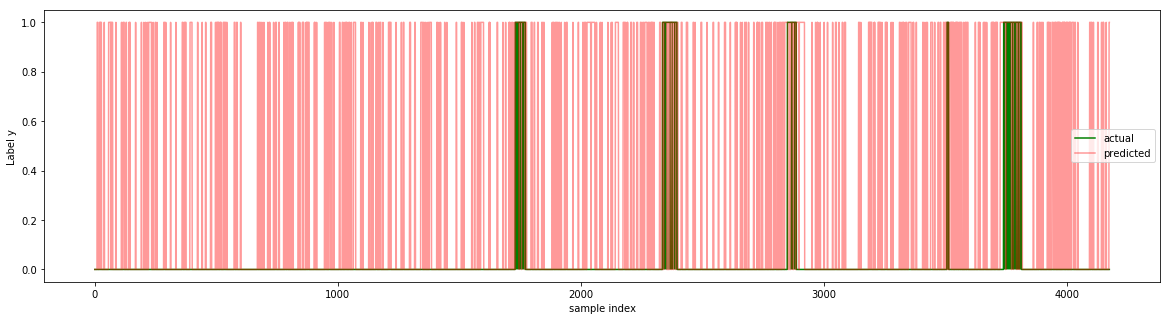

In [151]:
#detect again with the threshold provided by q_stat on the original data
predicted_labels3 = det_anomalies(n_data,att_data, num, threshold)
cm2 = estimate_confusion_matrix(y2, predicted_labels3)
accuracy2, precision2, recall2, F1_score2 = performance_metrics(cm2)
c_3 = compute_s(y2, predicted_labels3, 0.5)

print ("Confusion Matrix:", cm2)
print("Accuracy: %.2f" %accuracy2)
print("Precision: %.2f" % precision2)
print("Recall: %.2f" %recall2)
print("F_score: %.2f" % F1_score2)
print("Score : %.2f"%c_3)

# Visualize the predicted vs the true labels
plot(y2, predicted_labels3)

- Again we have to tune the threshold to result to few false positives

In [153]:
#test different number of threshold, where new_threshold > threshold obtained from the q stat.
thresholds = [9,9.2,9.3,9.4,9.5]
for i in thresholds:
    predict =  res > i 
    conf = estimate_confusion_matrix(y1, predict)
    print("Threshold:", i , "results to the following confusion matrix")
    print(conf)

Threshold: 9 results to the following confusion matrix
[[   0    6]
 [   0 8755]]
Threshold: 9.2 results to the following confusion matrix
[[   0    3]
 [   0 8758]]
Threshold: 9.3 results to the following confusion matrix
[[   0    3]
 [   0 8758]]
Threshold: 9.4 results to the following confusion matrix
[[   0    3]
 [   0 8758]]
Threshold: 9.5 results to the following confusion matrix
[[   0    3]
 [   0 8758]]


Confusion Matrix: [[  12   26]
 [ 207 3932]]
Accuracy: 0.94
Precision: 0.32
Recall: 0.05
F_score: 0.09
Score : 0.43


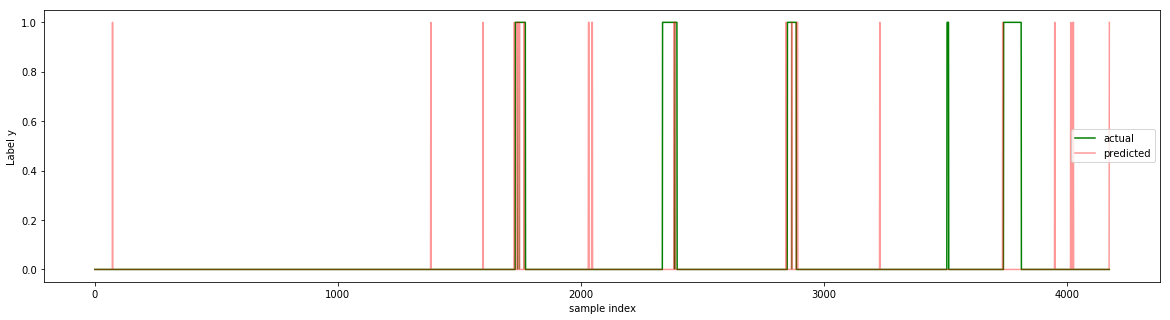

In [154]:
#detect again with the threshold provided by q_stat on the original data
thres =9.2
predicted_labels4 = det_anomalies(n_data,att_data, num, thres)
cm3 = estimate_confusion_matrix(y2, predicted_labels4)
accuracy3, precision3, recall3, F1_score3 = performance_metrics(cm3)
c_4 = compute_s(y2, predicted_labels4, 0.5)

print ("Confusion Matrix:", cm3)
print("Accuracy: %.2f" %accuracy3)
print("Precision: %.2f" % precision3)
print("Recall: %.2f" %recall3)
print("F_score: %.2f" % F1_score3)
print("Score : %.2f"%c_4)

# Visualize the predicted vs the true labels
plot(y2, predicted_labels4)